In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import cv2
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import tensorflow.keras.layers as L
from keras.optimizers import AdamW,Adam
import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy,SparseCategoricalCrossentropy
from efficientnet.tfkeras import EfficientNetB3,EfficientNetB0
import patoolib
from sklearn.model_selection import train_test_split

(512, 512, 3)


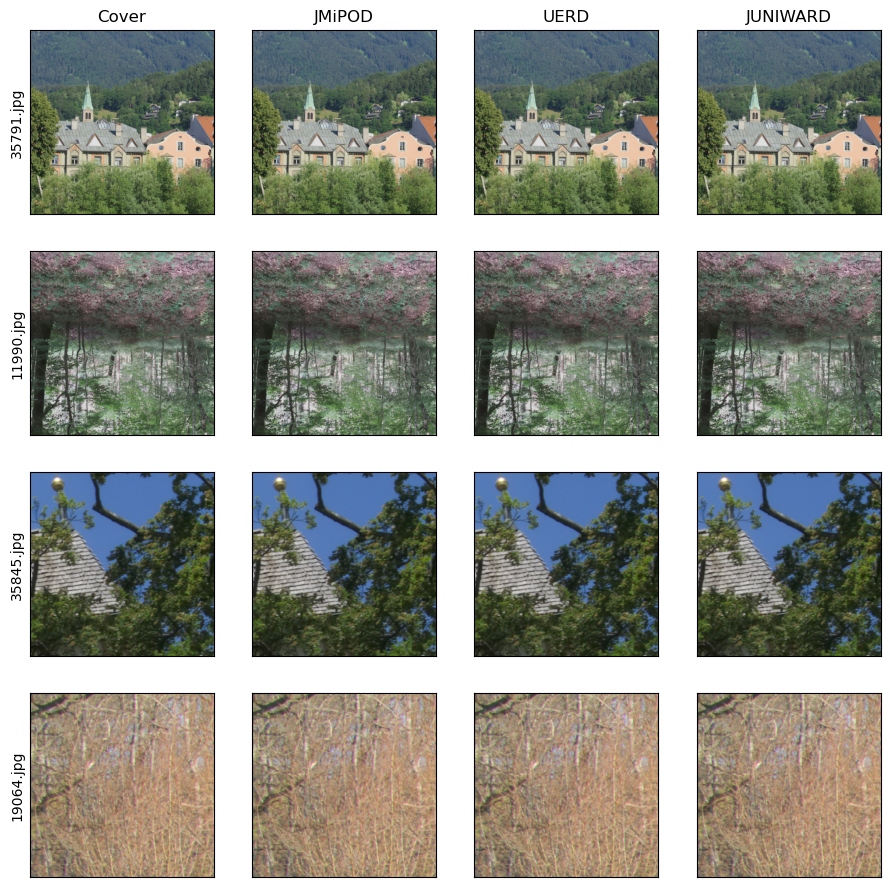

In [2]:
base_path = 'alaska2/'  
algorithm = ('Cover', 'JMiPOD', 'UERD', 'JUNIWARD') 

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(11, 11))

np.random.seed(57)

for i, id in enumerate(np.random.randint(0, 75001, 4)):
    id = '{:05d}'.format(id)
    
    cover_path = os.path.join(base_path, 'Cover', id + '.jpg')
    jmipod_path = os.path.join(base_path, 'JMiPOD', id + '.jpg')
    uerd_path = os.path.join(base_path, 'UERD', id + '.jpg')
    juniward_path = os.path.join(base_path, 'JUNIWARD', id + '.jpg')
    
    cover_img = plt.imread(cover_path)
    jmipod_img = plt.imread(jmipod_path)
    uerd_img = plt.imread(uerd_path)
    juniward_img = plt.imread(juniward_path)
    
    axes[i, 0].imshow(cover_img)
    axes[i, 1].imshow(jmipod_img)
    axes[i, 2].imshow(uerd_img)
    axes[i, 3].imshow(juniward_img)
    
    axes[i, 0].set(ylabel=id + '.jpg')

print(cover_img.shape)

for i, algo in enumerate(algorithm):
    axes[0, i].set(title=algo)

for ax in axes.flat:
    ax.set(xticks=[], yticks=[])

plt.show()

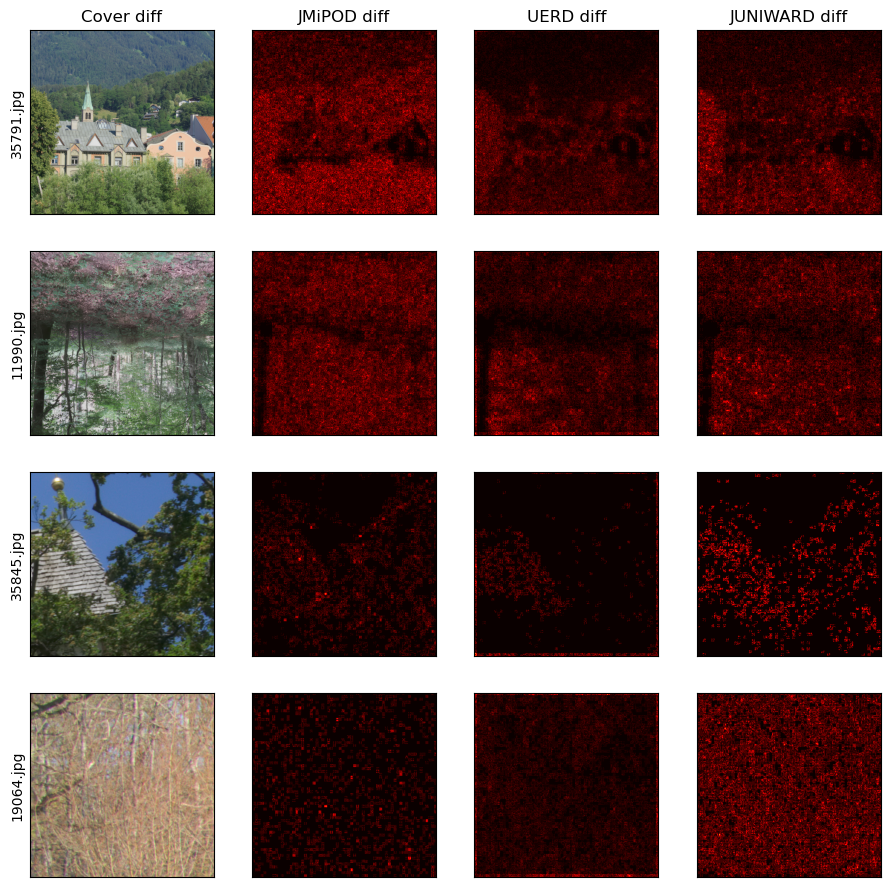

In [3]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(11, 11))

np.random.seed(57)

def disp_diff_img(alt, ref, ax, chnl=0):
    diff = np.abs(alt.astype(int) - ref.astype(int)).astype(np.uint8)
    ax.imshow(diff[:, :, chnl], vmin=0, vmax=np.amax(diff[:, :, chnl]), cmap='hot')

for i, id in enumerate(np.random.randint(0, 75001, 4)):
    id = '{:05d}'.format(id)
    
    cover_path = os.path.join(base_path, 'Cover', id + '.jpg')
    jmipod_path = os.path.join(base_path, 'JMiPOD', id + '.jpg')
    uerd_path = os.path.join(base_path, 'UERD', id + '.jpg')
    juniward_path = os.path.join(base_path, 'JUNIWARD', id + '.jpg')
    
    cover_img = plt.imread(cover_path)
    jmipod_img = plt.imread(jmipod_path)
    uerd_img = plt.imread(uerd_path)
    juniward_img = plt.imread(juniward_path)
    
    axes[i, 0].imshow(cover_img)
    disp_diff_img(jmipod_img, cover_img, axes[i, 1], 0)
    disp_diff_img(uerd_img, cover_img, axes[i, 2], 0)
    disp_diff_img(juniward_img, cover_img, axes[i, 3], 0)
    
    axes[i, 0].set(ylabel=id + '.jpg')

for i, algo in enumerate(algorithm):
    axes[0, i].set(title=algo + ' diff')

for ax in axes.flat:
    ax.set(xticks=[], yticks=[])

plt.show()

In [4]:
def append_path(pre):
    return np.vectorize(lambda file: os.path.join("alaska2/", pre, file))

In [5]:
train_filenames = os.listdir("alaska2/JUNIWARD/")
train_filenames[0]

'00001.jpg'

In [6]:
train_filenames = os.listdir("alaska2/Cover/")
train_filenames.sort(key=lambda x:x.split(".")[0])
train_filenames = np.array(train_filenames)
train_filenames 

array(['00001.jpg', '00002.jpg', '00003.jpg', ..., '80003.jpg',
       '80004.jpg', '80005.jpg'], dtype='<U9')

In [42]:
np.random.seed(1) 

positives = train_filenames.copy() 
negatives = train_filenames.copy()

np.random.shuffle(positives)
np.random.shuffle(negatives)

#TRAIN SAMPLES 
jmipod = append_path('JMiPOD')(positives[:2000])
juniward = append_path('JUNIWARD')(positives[2000:4000])
uerd = append_path('UERD')(positives[4000:6000])
pos_paths = np.concatenate([jmipod, juniward, uerd])

#TEST SAMPLES
jmipod_test = append_path('JMiPOD')(positives[2000:2025])
juniward_test = append_path('JUNIWARD')(positives[4000:4025])
uerd_test = append_path('UERD')(positives[6000:6025])

cover_test = append_path('Cover')(np.random.choice(negatives,25))
test_paths=np.concatenate([jmipod_test, juniward_test, uerd_test])

In [48]:
neg_paths = append_path('Cover')(np.random.choice(negatives,4000))
# neg_paths = append_path('Cover')(negatives[:750])

#TRAIN PATHS
train_paths = np.concatenate([pos_paths, neg_paths])

#TRAIN LABELS
train_labels=np.array([1] * len(pos_paths) + [0] * len(neg_paths))

#TEST LABELS
test_labels=np.array([1]*len(test_paths)+[0]*len(cover_test))

#TEST PATHS
test_paths=np.concatenate([test_paths, cover_test])

#TRAIN TEST SPLIT
train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, train_labels, test_size=0.2)

In [20]:
print('Train len: {}\nValid len: {}\nTest len: {}'.format(len(train_paths),len(valid_paths),len(test_paths)))

Train len: 2800
Valid len: 700
Test len: 125


In [21]:
def data_augment(image,label=None):
    image=tf.image.random_flip_left_right(image)
    image=tf.image.random_flip_up_down(image)
    image=tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    image = tf.image.random_crop(image, size=[336, 336, tf.shape(image)[-1]])
    
    if label is None:
        return image
    else:
        return image,label
    
def decode_image(filename, label=None, image_size=(512,512)):
    bits=tf.io.read_file(filename)
    image=tf.image.decode_jpeg(bits,channels=3)
    image=tf.cast(image,tf.float32) / 255.0
    image=tf.image.resize(image,image_size)
    
    if label is None:
        return image
    else:
        return image,label

In [44]:
train_dataset = (tf.data.Dataset
                 .from_tensor_slices((train_paths,train_labels))
                 .map(decode_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
                 .map(data_augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)  # Apply data augmentation
                 .cache()
                 .batch(16)
                 .prefetch(tf.data.experimental.AUTOTUNE)
                )
valid_dataset= (tf.data.Dataset
                .from_tensor_slices((valid_paths,valid_labels))
                .map(decode_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .batch(16)
                .prefetch(tf.data.experimental.AUTOTUNE)
               )
test_dataset=(tf.data.Dataset
                .from_tensor_slices((test_paths,test_labels))
                .map(decode_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .batch(1)
                .prefetch(tf.data.experimental.AUTOTUNE)
               )

In [40]:
train_dataset_size = len(train_dataset)
print("Train dataset size:", train_dataset_size)
valid_dataset_size = len(valid_dataset)
print("Valid dataset size:", valid_dataset_size)
test_dataset_size = len(test_dataset)
print("Test dataset size:", test_dataset_size)

Train dataset size: 175
Valid dataset size: 44
Test dataset size: 100


In [25]:
base_model = EfficientNetB3(weights='imagenet', include_top=False)

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1)(x)  

model = tf.keras.Model(inputs=base_model.input, outputs=x)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-4), loss=BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 40)       1080      ['input_4[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, None, None, 40)       160       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, None, None, 40)       0         ['stem_bn[0][0]']       

In [ ]:
history= model.fit(
    train_dataset,
    epochs=1,
    validation_data=valid_dataset)

In [14]:
model.save('models/tf-2-e1-val79')

INFO:tensorflow:Assets written to: models/tf-2-e1-val79\assets


INFO:tensorflow:Assets written to: models/tf-2-e1-val79\assets


In [46]:
model = tf.keras.models.load_model('models/tf-2-e1-val79')

In [35]:
print(history.keys())
history.values()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


dict_values([[0.5199272632598877], [0.7739999890327454], [0.506502628326416], [0.7906666398048401]])

In [47]:
history= model.fit(
    train_dataset,
    epochs=1,
    validation_data=valid_dataset)

325/325 [==============================] - 774s 2s/step - loss: 0.2809 - accuracy: 0.9227 - val_loss: 0.3025 - val_accuracy: 0.9162


In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)

100/100 [==============================] - 22s 220ms/step - loss: 0.7410 - accuracy: 0.7500


In [99]:
image=decode_image('alaska2/JUNIWARD/60000.jpg')
image = tf.expand_dims(image, axis=0)
model.predict(image)

1/1 [==============================] - 0s 221ms/step


array([[1.7393794]], dtype=float32)